In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import os
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from sklearn.metrics import accuracy_score

from torchlars import LARS

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1, 2"

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.set_device(device)

cuda:0


In [4]:
from loss import *
from utils import pro2idx, load_data, seq_dic
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from Bio import SeqIO

In [5]:
max_seq_len = 700

In [6]:
records = list(SeqIO.parse("../data/protein/pdb_seqres.txt", "fasta"))

proteins = [''.join((records[i].seq)) for i in range(len(records)) if len(records[i].seq) <= max_seq_len and len(records[i].seq) >= 100]

train_pro, test_pro = train_test_split(proteins, test_size=0.2, random_state = 7)

In [7]:
len(train_pro)

305669

In [8]:
train_pro, test_pro = load_data(max_seq_len=700)

92.79% training proteins (453388) selected with length <= 700
92.60% testing proteins (106763) selected with length <= 700


In [8]:
class ProteinGlobalDataset(Dataset):
    """Protein Adjacent views."""

    def __init__(self, proteins, with_label = False):
        """
        Args:
            proteins (list): list of proteins 
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.proteins = proteins
        self.with_label = with_label

    def __len__(self):
        return len(self.proteins)

    def __getitem__(self, idx):
        pro = self.proteins[idx]
        
        if not self.with_label:
            r = random.uniform(0, 1)
            if r <= 0.5:
                
                first_start = random.randint(0, len(pro) // 6)
                first_end = random.randint(len(pro) // 6 * 5, len(pro))
                x = pro[first_start:first_end+1]
                
                second_start = random.randint(first_start + 1, len(x) // 6 + first_start + 1)
                second_end = random.randint(len(x) // 6 * 5 + first_start + 1, first_end - 1)
                
                assert first_start < first_end
                assert second_start < second_end
                assert first_start < second_start
                assert first_end > second_end
                
                x_aug = pro[second_start:second_end+1]
                x = pro2idx(x)
                x_aug = pro2idx(x_aug)
                return x, len(pro), x_aug, len(x_aug)
                
            else:
                shred = random.randint(len(pro) // 6, len(pro) // 6 * 5)
                first_start = random.randint(0, shred - 1)
                first_end = random.randint(first_start + 1, shred)
                second_start = random.randint(shred, len(pro) - 1)
                second_end = random.randint(second_start + 1, len(pro))

                x = pro[first_start:first_end+1]
                x_aug = pro[second_start:second_end+1]
                x = pro2idx(x)
                x_aug = pro2idx(x_aug)
                
                assert first_start < first_end
                assert second_start < second_end
                assert first_start < second_start
                assert first_end < second_end

                return x, len(pro), x_aug, len(x_aug)
            
        else:
            pass


In [9]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.embed = nn.Embedding(27, 128)
        self.gru1 = nn.GRU(128, 96, 2, batch_first=True)
        self.gru2 = nn.GRU(96, 96, 2, batch_first=True)
        self.maxpool = nn.AdaptiveMaxPool1d(1)
        

    def forward(self, x, x_batch_len):
        x = self.embed(x)
        x = nn.utils.rnn.pack_padded_sequence(x, x_batch_len, batch_first=True, enforce_sorted=False)
        
        self.gru1.flatten_parameters()
        x, h_n = self.gru1(x)
        
        self.gru2.flatten_parameters()
        x, _ = self.gru2(x, h_n)
        
        
        x, _ = torch.nn.utils.rnn.pad_packed_sequence(x, batch_first=True)
        x = x.contiguous()
        x.transpose_(1, 2)
        
        
        x = self.maxpool(x)
        x = torch.flatten(x, start_dim=1)
        return x
    
class Projection(nn.Module):
    def __init__(self):
        super(Projection, self).__init__()
        self.fc1 = nn.Linear(96, 32)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return x
    
    
class Contrastive(nn.Module):
    def __init__(self, encoder, projection):
        super(Contrastive, self).__init__()
        self.encoder = encoder
        self.projection = projection
        
    def forward(self, x, x_len, x_aug, x_aug_len):
        u = self.projection(self.encoder(x, x_len))
        v = self.projection(self.encoder(x_aug, x_aug_len))
        return u, v

In [10]:
params = {'batch_size': 1024,
          'shuffle': True,
          'num_workers': 6}
max_epochs = 200

training_set = ProteinGlobalDataset(train_pro[:100000])
print(len(training_set))
training_generator = DataLoader(training_set, **params)


encoder = Encoder()
projection = Projection()
contrastive = Contrastive(encoder, projection)

if torch.cuda.device_count() > 1:
    encoder = nn.DataParallel(encoder, device_ids=[0, 1])
    projection = nn.DataParallel(projection, device_ids=[0, 1])
    contrastive = nn.DataParallel(contrastive, device_ids=[0, 1])

encoder.to(device)
projection.to(device)
contrastive.to(device)


# opt = optim.Adam(contrastive.parameters(), lr=0.001, betas=(0.9, 0.999))
base_optimizer = optim.SGD(contrastive.parameters(), lr=0.01)
opt = LARS(optimizer=base_optimizer, eps=1e-8, trust_coef=0.001)

100000


In [ ]:
history = []
for epoch in range(max_epochs):
    train_loss = 0
    
    for x_batch, x_batch_len, x_aug_batch, x_aug_batch_len in tqdm(training_generator):
        x_batch, x_batch_len = x_batch.to(device), x_batch_len.to(device)
        x_aug_batch, x_aug_batch_len = x_aug_batch.to(device), x_aug_batch_len .to(device)
        u, v = contrastive(x_batch, x_batch_len, x_aug_batch, x_aug_batch_len)

        loss = cus_loss(u, v, 0.1)
        loss.backward()
        opt.step()

        train_loss += loss.item()
    history.append(train_loss) 
    print('Epoch {}: Average loss: {:.4f}\n'.format(
            epoch, train_loss))




  0%|          | 0/98 [00:00<?, ?it/s]

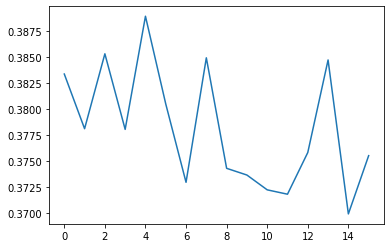

In [12]:
plt.plot(history)
plt.show()

In [14]:
torch.save(encoder.state_dict(), "models/gru_encoder.pt")
torch.save(projection.state_dict(), "models/gru_projection.pt")

In [134]:
Encoder()(x_batch, x_batch_len).shape

torch.Size([16, 96])

In [126]:
embed = nn.Embedding(27, 128)
x = embed(x_batch)
x.shape

torch.Size([16, 700, 128])

In [127]:
gru1 = nn.GRU(128, 96, 2, batch_first=True)
gru2 = nn.GRU(96, 96, 2, batch_first=True)
x = nn.utils.rnn.pack_padded_sequence(x, x_batch_len, batch_first=True, enforce_sorted=False)

x, h_n = gru1(x)
x, _ = gru2(x, h_n)

x, _ = torch.nn.utils.rnn.pad_packed_sequence(x, batch_first=True)
x = x.contiguous()
x.transpose_(1, 2)
x.shape

torch.Size([16, 96, 444])

In [124]:
maxpool = nn.AdaptiveMaxPool1d(1)
result = maxpool(result)
result.shape

torch.Size([16, 96, 1])

In [110]:
result = torch.flatten(result, start_dim=1)
result.shape

torch.Size([16, 96])